# Box-Jenkins ARIMA Procedure

In [7]:
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import pandas_datareader.data as pdr

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

import seaborn as sns

plt.style.use('seaborn-whitegrid')
%matplotlib inline

import itertools

# Data description

- 활용 데이터 1: AirPassengers.csv
    - 1949년 ~ 1960년 매달 비행기 탑승객 수가에 대한 시계열 데이터
    - 데이터 구조 : 144 X 1

In [8]:
data = pd.read_csv('AirPassengers.csv')
data = data.rename(columns={'Month': 'month', '#Passengers': 'passengers'})
data['month'] = pd.to_datetime(data['month'])
data = data.set_index('month')
data.head()

,passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


# 3. Box-Jenkins ARIMA Procedure
- 3.1 Data Preprocessing
- 3.2 Identify Model to be Tentatively Entertainted
- 3.3 Estimate Parameters
- 3.4 Diagnosis Check
- 3.5 User Model to Forecast

## 3.1 Data Preprocessing

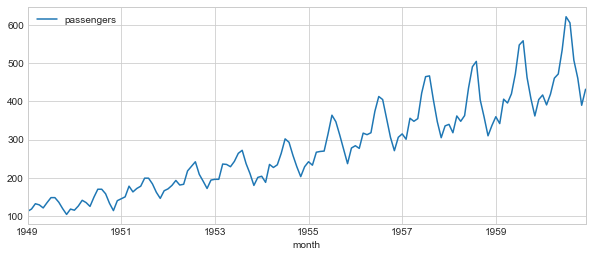

In [10]:
# Raw Data plot
fig = data.plot(figsize=(10,4))

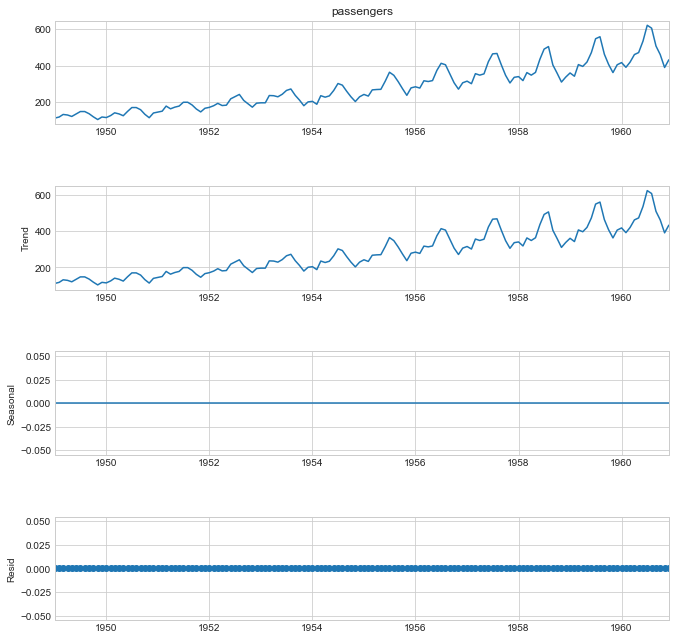

In [11]:
decompostition = sm.tsa.seasonal_decompose(data['passengers'], model='additive', period=1)
fig = decompostition.plot()
fig.set_size_inches(10,10)
plt.show()

- 첫 번째 플롯이 실젝 관측치에 대한 그래프, 두 번째는 트렌드, 세 번째가 Seasonal, 네번째가 residual에 대한 plot
- Observed : observed data
- Trend : The estimated trend component
- Seasonal : The estimated seasonal component
- resid : The estimated residuals

- decomposition 방법

## 3.2 Identify Model to be Tentatively Enterainted

In [12]:
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

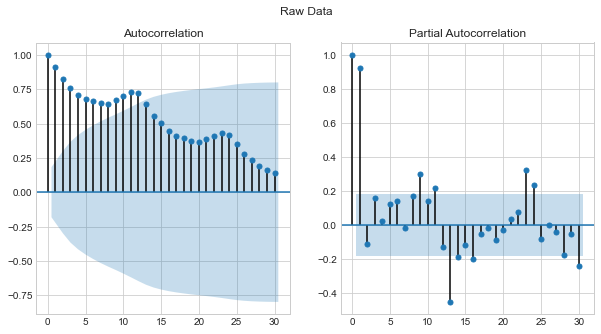

In [17]:
# ACF, PACF Plot

fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(), lags=30, ax=ax[1]); # Modiy not to generate graph twice

- ACF 그래프의 파도 모양을 확인 할 수 있다.
- 이런 형태는 트렌드가 있어서 Non-Stationary한 데이터의 모습이다.
- 3가지 플롯에서 공통적인 사실은 정성적이지만 정상성을 가지고 있지 않다는 것을 알 수 있다.

# Differencing
- 차분 : 현 시점 데이터에서 d시점 이전 데이터를 뺀 것

In [18]:
# differencing

diff_train_data = train_data.copy()
diff_train_data = diff_train_data['passengers'].diff()
diff_train_data = diff_train_data.dropna()

print('####### Raw Data ########')
print(train_data)
print('### Differenced Data ###')
print(diff_train_data)

####### Raw Data ########
            passengers
month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
...                ...
1958-03-01         362
1958-04-01         348
1958-05-01         363
1958-06-01         435
1958-07-01         491

[115 rows x 1 columns]
### Differenced Data ###
month
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
1949-06-01    14.0
              ... 
1958-03-01    44.0
1958-04-01   -14.0
1958-05-01    15.0
1958-06-01    72.0
1958-07-01    56.0
Name: passengers, Length: 114, dtype: float64


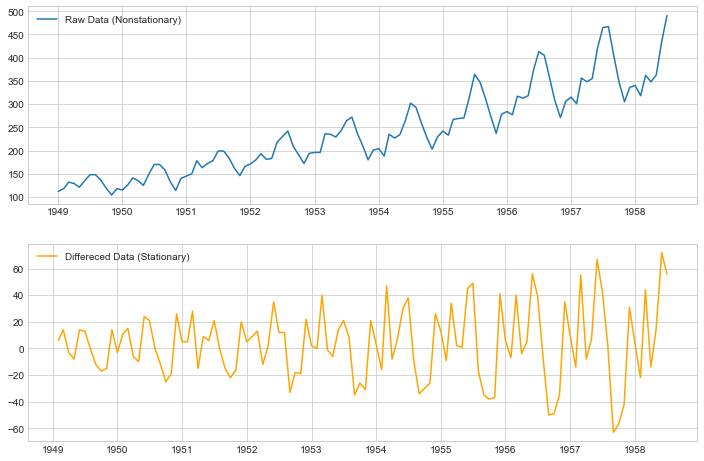

In [19]:
# Differenced data plot

plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(train_data['passengers'])
plt.legend(['Raw Data (Nonstationary)'])
plt.subplot(212)
plt.plot(diff_train_data, 'orange') # first difference (t - (t-1))
plt.legend(['Differeced Data (Stationary)'])
plt.show()

- 노란색 plot이 1차 차분한 데이터
- 1차 차분한 데이터가 좀 더 stationary한 것을 볼 수 있다.

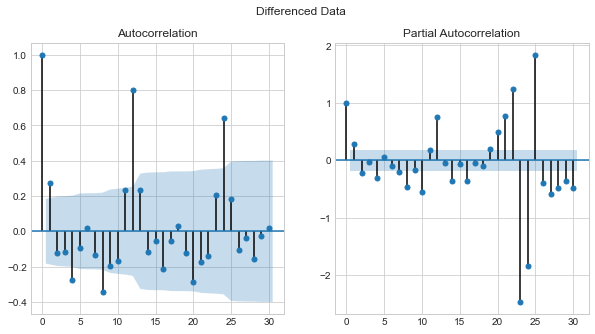

In [20]:
# ACF, PACF Plot

fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Differenced Data')
sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=30, ax=ax[1]); # Modiy not to generate graph twice

- 차분된 데이터를 보면 사인 그래프와 같은 개형을 띄고 있다.

## Identification ARIMA Model

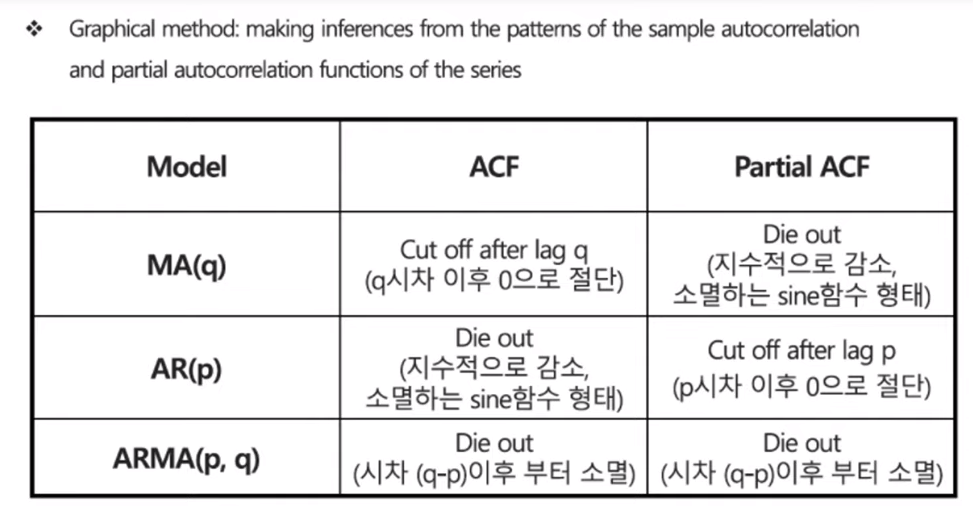

## 3.3 Estimate Parameters

In [21]:
# ARIMA Model fitting
# The (p, d, q) order of the model for the number of AR Parameters, differences,and MA parameters to use.

model = ARIMA(train_data.values, order=(1,1,0))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  114
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -531.720
Method:                       css-mle   S.D. of innovations             25.659
Date:                Wed, 27 Jan 2021   AIC                           1069.440
Time:                        23:27:13   BIC                           1077.649
Sample:                             1   HQIC                          1072.771
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5124      3.329      1.055      0.291      -3.012      10.037
ar.L1.D.y      0.2803      0.091      3.077      0.002       0.102       0.459
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.5681           +0.0000j            3.5681            0.0000
-----------------------------------------------------------------------------
"""

## 3.4.1 Diagnosis Check - ARIMA

In [22]:
# Parameter search

print('Examples of parameter combinations for Seasonal ARIMA...')

p = range(0, 3)
d = range(1, 2)
q = range(0, 3)

pdq = list(itertools.product(p, d, q))

aic = []

for i in pdq:
    model = ARIMA(train_data.values, order=(i))
    model_fit = model.fit()
    print(f'ARIMA: {i} >> AIC : {round(model_fit.aic, 2)}')
    aic.append(round(model_fit.aic, 2))

Examples of parameter combinations for Seasonal ARIMA...
ARIMA: (0, 1, 0) >> AIC : 1076.52
ARIMA: (0, 1, 1) >> AIC : 1064.62
ARIMA: (0, 1, 2) >> AIC : 1061.08
ARIMA: (1, 1, 0) >> AIC : 1069.44
ARIMA: (1, 1, 1) >> AIC : 1058.83
ARIMA: (1, 1, 2) >> AIC : 1046.05
ARIMA: (2, 1, 0) >> AIC : 1066.2
ARIMA: (2, 1, 1) >> AIC : 1045.66
ARIMA: (2, 1, 2) >> AIC : 1047.19


In [23]:
# Search optimal parameters

optimal = [(pdq[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal

[((2, 1, 1), 1045.66)]

In [24]:
model_opt = ARIMA(train_data.values, order=optimal[0][0])
model_opt_fit = model_opt.fit()

model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  114
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -517.830
Method:                       css-mle   S.D. of innovations             22.317
Date:                Wed, 27 Jan 2021   AIC                           1045.660
Time:                        23:35:08   BIC                           1059.341
Sample:                             1   HQIC                          1051.212
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5600      0.163     15.753      0.000       2.241       2.878
ar.L1.D.y      1.0890      0.085     12.816      0.000       0.922       1.256
ar.L2.D.y     -0.4729      0.086     -5.527      0.000      -0.641      -0.305
ma.L1.D.y     -0.9999      0.040    -25.219      0.000      -1.078      -0.922
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1513           -0.8883j            1.4541           -0.1046
AR.2            1.1513           +0.8883j            1.4541            0.1046
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

## 3.5.1 use Model to Forecast - ARIMA

In [30]:
prediction = model_opt_fit.forecast(len(test_data))
predicted_value = prediction[0]
predicted_up = prediction[2][:, 0]
predicted_lb = prediction[2][:, 1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

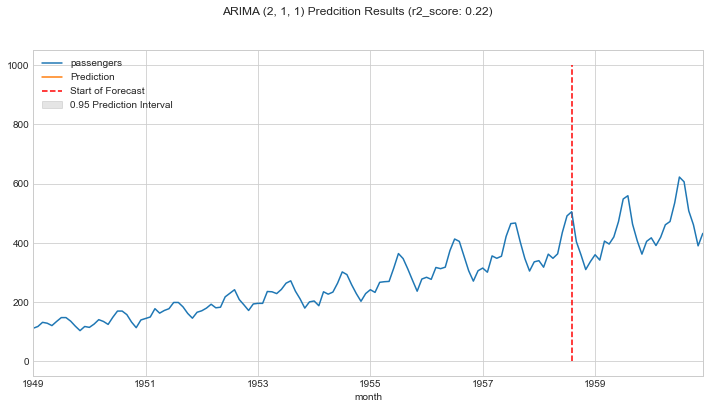

In [32]:
fig, ax = plt.subplots(figsize=(12, 6))
data.plot(ax=ax);
ax.vlines('1958-08-01', 0, 1000, linestyle='--', color='r', label='Start of Forecast');
ax.plot(predict_index, predicted_value, label='Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_up, color='k', alpha=0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA {optimal[0][0]} Predcition Results (r2_score: {round(r2, 2)})')
plt.show()

## 3.4.2 Diagnosis Check - SARIMA

In [33]:
# Parameter Search

print("Examples of parameter combinations for Seasonal ARIMA...")
p = range(0, 3)
d = range(1, 2)
q = range(0, 3)

pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

aic = []
params = []
for i in pdq:
    for j in seasonal_pdq:
        try:
            model = SARIMAX(train_data.values, order=(i), seasonal_order=(j))
            model_fit = model.fit()
            print(f'SARIMA: {i}{j} >> AIC : {round(model_fit.aic, 2)}')
            aic.append(round(model_fit.aic,2))
            params.append((i, j))
        except:
            continue

Examples of parameter combinations for Seasonal ARIMA...
SARIMA: (0, 1, 0)(0, 1, 0, 12) >> AIC : 757.83
SARIMA: (0, 1, 0)(0, 1, 1, 12) >> AIC : 756.99
SARIMA: (0, 1, 0)(0, 1, 2, 12) >> AIC : 758.83
SARIMA: (0, 1, 0)(1, 1, 0, 12) >> AIC : 756.96
SARIMA: (0, 1, 0)(1, 1, 1, 12) >> AIC : 758.92
SARIMA: (0, 1, 0)(1, 1, 2, 12) >> AIC : 754.42
SARIMA: (0, 1, 0)(2, 1, 0, 12) >> AIC : 758.87
SARIMA: (0, 1, 0)(2, 1, 1, 12) >> AIC : 760.73
SARIMA: (0, 1, 0)(2, 1, 2, 12) >> AIC : 754.91
SARIMA: (0, 1, 1)(0, 1, 0, 12) >> AIC : 756.01
SARIMA: (0, 1, 1)(0, 1, 1, 12) >> AIC : 756.38
SARIMA: (0, 1, 1)(0, 1, 2, 12) >> AIC : 757.65
SARIMA: (0, 1, 1)(1, 1, 0, 12) >> AIC : 756.17
SARIMA: (0, 1, 1)(1, 1, 1, 12) >> AIC : 758.11
SARIMA: (0, 1, 1)(1, 1, 2, 12) >> AIC : 751.73
SARIMA: (0, 1, 1)(2, 1, 0, 12) >> AIC : 757.99
SARIMA: (0, 1, 1)(2, 1, 1, 12) >> AIC : 753.78
SARIMA: (0, 1, 1)(2, 1, 2, 12) >> AIC : 75.42
SARIMA: (0, 1, 2)(0, 1, 0, 12) >> AIC : 757.78
SARIMA: (0, 1, 2)(0, 1, 1, 12) >> AIC : 758.04
SARI

In [34]:
# Seach optimal paramters
optimal = [(params[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal

[(((0, 1, 1), (2, 1, 2, 12)), 75.42)]

In [35]:
model_opt = SARIMAX(train_data.values, order=optimal[0][0][0], seasonal_order=optimal[0][0][1])
model_opt_fit = model_opt.fit()

model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  115
Model:             SARIMAX(0, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood                 -31.708
Date:                                 Thu, 28 Jan 2021   AIC                             75.416
Time:                                         00:02:59   BIC                             91.166
Sample:                                              0   HQIC                            81.794
                                                 - 115                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3467   7.62e-07  -4.55e+05      0.000      -0.347      -0.347
ar.S.L12       0.0015   3.82e-07   3855.709      0.000       0.001       0.001
ar.S.L24       0.9985   4.06e-07   2.46e+06      0.000       0.999       0.999
ma.S.L12       0.0014   6.38e-07   2116.795      0.000       0.001       0.001
ma.S.L24      -0.9955   1.33e-07  -7.49e+06      0.000      -0.996      -0.996
sigma2        92.6354   3.34e-10   2.78e+11      0.000      92.635      92.635
===================================================================================
Ljung-Box (L1) (Q):                  30.45   Jarque-Bera (JB):              8213.81
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                             6.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        45.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.02e+21. Standard errors may be unstable.
"""

## 3.5.2 use Model to Forecast - SARIMA

In [39]:
prediction = model_opt_fit.get_forecast(len(test_data))
predicted_value = prediction.predicted_mean
predicted_ub = prediction.conf_int()[:,0]
predicted_lb = prediction.conf_int()[:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

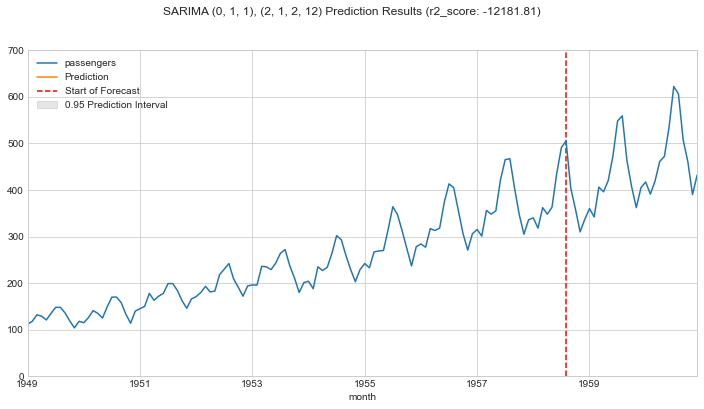

In [48]:
fig, ax = plt.subplots(figsize=(12, 6))
data.plot(ax=ax);
ax.vlines('1958-08-01', 0, 700, linestyle='--', color='r', label='Start of Forecast')
ax.plot(predict_index, predicted_value, label='Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.ylim((0, 700))
plt.suptitle(f'SARIMA {optimal[0][0][0]}, {optimal[0][0][1]} Prediction Results (r2_score: {round(r2, 2)})')
plt.show()

## 3.4.3 Diagnosis Check - auto_arima

In [50]:
# Parameter Search

auto_arima_model = auto_arima(train_data, start_p=1, start_q=1, 
                              max_p=3, max_q=3, m=12, seasonal=True, 
                              d=1, D=1, max_P=3, max_Q=3, # start Large P, Q는 디폴트로 1로 설정되어있음
                              trace=True, # 각각의 결과값을 보여주는 파라미터
                              error_action='ignore', suppress_warning=True,
                              stepwise=False) # 학습이 끝나면 저절로 최적의 파라미터로 모델이 설정됨.

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=757.826, Time=0.02 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=756.988, Time=0.13 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=758.826, Time=0.48 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=758.186, Time=0.70 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=756.959, Time=0.08 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=758.922, Time=0.21 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=1.35 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=754.685, Time=2.17 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=758.869, Time=0.20 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=760.726, Time=0.84 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=1.94 sec
 ARIMA(0,1,0)(2,1,3)[12]             : AIC=756.686, Time=2.70 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=759.643, Time=0.54 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=inf, Time=3.41 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=756.688, Time=3.69 sec
 ARIMA(0,1,1)(0,1,0)[1

In [51]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                          y   No. Observations:                  115
Model:             SARIMAX(1, 1, 0)x(1, 1, [1, 2, 3], 12)   Log Likelihood                -370.278
Date:                                    Thu, 28 Jan 2021   AIC                            752.557
Time:                                            00:22:31   BIC                            768.307
Sample:                                                 0   HQIC                           758.934
                                                    - 115                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2218      0.093     -2.388      0.017      -0.404      -0.040
ar.S.L12       0.9288      0.275      3.374      0.001       0.389       1.468
ma.S.L12      -1.2065      0.448     -2.692      0.007      -2.085      -0.328
ma.S.L24       0.2771      0.174      1.596      0.111      -0.063       0.618
ma.S.L36       0.1251      0.164      0.765      0.444      -0.195       0.446
sigma2        75.0386     19.073      3.934      0.000      37.657     112.421
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.50
Prob(Q):                              0.91   Prob(JB):                         0.29
Heteroskedasticity (H):               1.05   Skew:                             0.37
Prob(H) (two-sided):                  0.90   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 3.5.3 use Model to Forecast - auto_arima

In [52]:
prediction = auto_arima_model.predict(len(test_data), return_conf_int=True)
predicted_value = prediction[0]
predicted_ub = prediction[1][:,0]
predicted_lb = prediction[1][:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

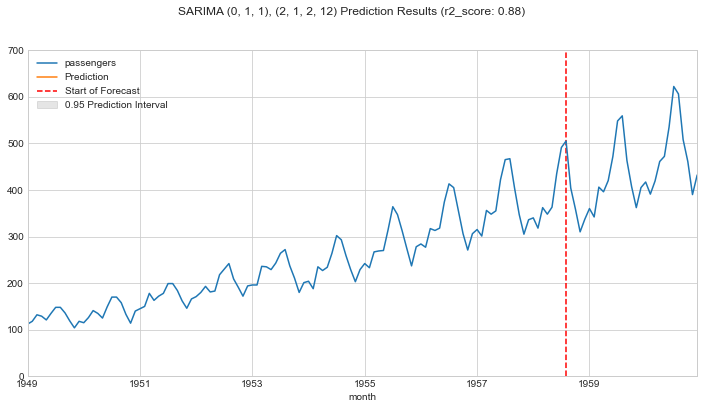

In [53]:
fig, ax = plt.subplots(figsize=(12, 6))
data.plot(ax=ax);
ax.vlines('1958-08-01', 0, 700, linestyle='--', color='r', label='Start of Forecast')
ax.plot(predict_index, predicted_value, label='Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.ylim((0, 700))
plt.suptitle(f'SARIMA {optimal[0][0][0]}, {optimal[0][0][1]} Prediction Results (r2_score: {round(r2, 2)})')
plt.show()

# 4. Case Study : 주가 예측

## Data description

- 활용 데이터 : 실제 주가 예측
    - 상장 법인 목록에서 종목코드를 통해 기업 주가 다운로드
    - 최근 5년간 주식 관련 정보에 대한 시계열 데이터
    - 데이터 구조 : 1219 X 6

In [54]:
def get_code(df, name):
    code = df.query("name=='{}'".format(name))['code'].to_string(index=False)
    code = code.strip()
    return code

In [56]:
code_data = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0]

In [57]:
code_data # 2880 rows x 9 columns

,회사명,종목코드,업종,주요제품,상장일,결산월,대표자명,홈페이지,지역
0,DSR,155660,1차 비철금속 제조업,합섬섬유로프,2013-05-15,12월,홍석빈,http://www.dsr.com,부산광역시
1,GS글로벌,1250,상품 종합 도매업,"수출입업(시멘트,철강금속,전기전자,섬유,기계화학),상품중개,광업,채석업/하수처리 서...",1976-06-26,12월,김태형,http://www.gsgcorp.com,서울특별시
2,HDC현대산업개발,294870,건물 건설업,"외주주택, 자체공사, 일반건축, 토목 등",2018-06-12,12월,"권순호, 정경구",http://www.hdc-dvp.com,서울특별시
3,KG케미칼,1390,기초 화학물질 제조업,"콘크리트혼화제, 비료, 친환경농자재, 수처리제",1989-08-25,12월,"곽정현, 김재익",http://www.kgchem.co.kr,울산광역시
4,LG이노텍,11070,전자부품 제조업,기타 전자부품 제조업,2008-07-24,12월,정철동,http://www.lginnotek.co.kr,서울특별시
...,...,...,...,...,...,...,...,...,...
2410,툴젠,199800,자연과학 및 공학 연구개발업,"유전자가위 (유전체 교정 도구) 및 이를 이용한 유전자세포치료제, 고부가가치 가축,...",2014-06-25,12월,"김영호, 이병화(각자 대표이사)",http://www.toolgen.com,서울특별시
2411,플럼라인생명과학,222670,자연과학 및 공학 연구개발업,"강아지암치료제,돼지DNA테라피",2015-07-28,12월,김앤토니경태,http://www.plsdna.com,서울특별시
2412,피엔에이치테크,239890,기초 화학물질 제조업,"OLED완성체, OLED중간체, Pd촉매",2016-08-16,12월,현서용,http://www.phtech.co.kr,경기도
2413,한국미라클피플사,331660,기타 화학제품 제조업,"은나노스텝, 닥터오렌지 등",2019-10-28,12월,이호경,http://www.kmpc.co.kr,경기도


In [58]:
code_data = code_data[['회사명', '종목코드']]
code_data = code_data.rename(columns={'회사명':'name', '종목코드':'code'})
code_data.code = code_data.code.map('{:06d}'.format)

In [61]:
stock_code = get_code(code_data, 'LG이노텍')
stock_code = stock_code + '.KS'
stock_data = pdr.get_data_yahoo(stock_code)


stock_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-02-01,87700.0,82800.0,83000.0,86600.0,332861.0,85362.945312
2016-02-02,86600.0,84800.0,86600.0,84800.0,133220.0,83588.664062
2016-02-03,85000.0,81800.0,84100.0,81900.0,166500.0,80730.093750
2016-02-04,84900.0,82000.0,82500.0,83500.0,130164.0,82307.242188
2016-02-05,85200.0,83400.0,83500.0,84300.0,63854.0,83095.804688
...,...,...,...,...,...,...
2021-01-22,215000.0,200000.0,207000.0,200000.0,496533.0,200000.000000
2021-01-25,212000.0,202000.0,203500.0,210500.0,461840.0,210500.000000
2021-01-26,238000.0,219000.0,221000.0,224500.0,1625867.0,224500.000000


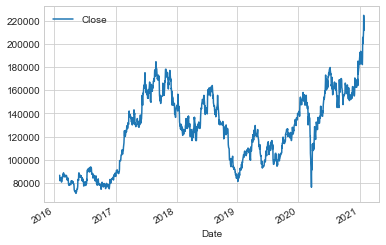

In [62]:
stock_data = stock_data[['Close']]
fig = stock_data.plot()

In [63]:
stock_data_train, stock_data_test = train_test_split(stock_data, test_size=0.05, shuffle=False)

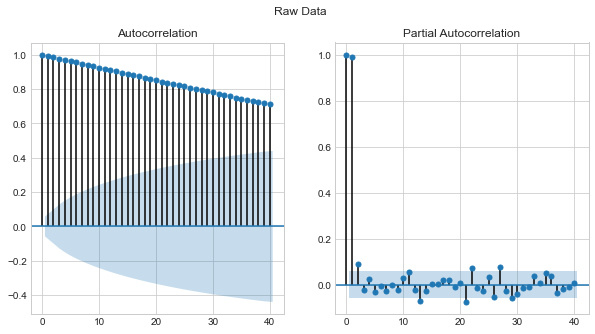

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(stock_data_train.values.squeeze(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(stock_data_train.values.squeeze(), lags=40, ax=ax[1]);

In [68]:
diff_stock_data_train = stock_data_train.copy()
diff_stock_data_train = diff_stock_data_train['Close'].diff()
diff_stock_data_train = diff_stock_data_train.dropna()

print("######## Raw Data ########")
print(stock_data_train)
print('### Differenced Data ###')
print(diff_stock_data_train)

######## Raw Data ########
               Close
Date                
2016-02-01   86600.0
2016-02-02   84800.0
2016-02-03   81900.0
2016-02-04   83500.0
2016-02-05   84300.0
...              ...
2020-10-26  152500.0
2020-10-27  155000.0
2020-10-28  162000.0
2020-10-29  158000.0
2020-10-30  152000.0

[1158 rows x 1 columns]
### Differenced Data ###
Date
2016-02-02   -1800.0
2016-02-03   -2900.0
2016-02-04    1600.0
2016-02-05     800.0
2016-02-11   -2000.0
               ...  
2020-10-26   -5000.0
2020-10-27    2500.0
2020-10-28    7000.0
2020-10-29   -4000.0
2020-10-30   -6000.0
Name: Close, Length: 1157, dtype: float64


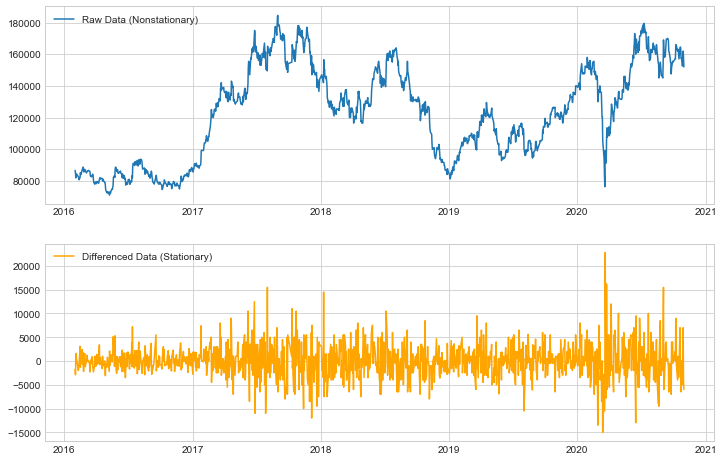

In [69]:
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(stock_data_train['Close'])
plt.legend(['Raw Data (Nonstationary)'])
plt.subplot(212)
plt.plot(diff_stock_data_train, 'orange') # first difference (t-(t-1))
plt.legend(['Differenced Data (Stationary)'])
plt.show()

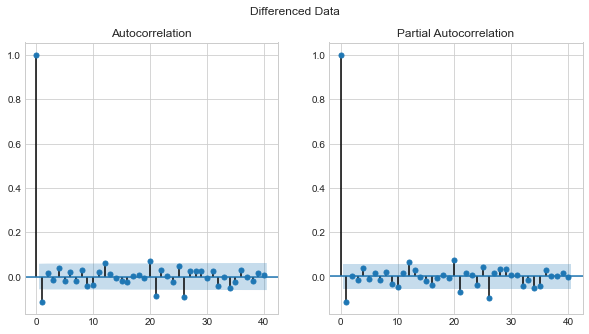

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Differenced Data')
sm.graphics.tsa.plot_acf(diff_stock_data_train.values.squeeze(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_stock_data_train.values.squeeze(), lags=40, ax=ax[1]);

In [71]:
# Parameter Search

auto_arima_model = auto_arima(stock_data_train, 
                              start_p=1, start_q=1, 
                              max_p=3, max_q=3, 
                              seasonal=False, 
                              d=1, trace=True, error_action='ignore',
                              suppress_warnings=True, 
                              stepwise=False)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=22229.897, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22219.083, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=22221.081, Time=0.16 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=22223.094, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22219.243, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=22221.076, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=22221.753, Time=0.49 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=22223.209, Time=0.65 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=22221.079, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=22223.073, Time=0.23 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=22223.384, Time=0.64 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=22227.079, Time=0.31 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=22223.034, Time=0.28 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=22223.003, Time=0.69 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=22224.754, Time=0.88

In [72]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1158
Model:               SARIMAX(0, 1, 1)   Log Likelihood              -11106.542
Date:                Thu, 28 Jan 2021   AIC                          22219.083
Time:                        12:57:32   BIC                          22234.244
Sample:                             0   HQIC                         22224.805
                               - 1158                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     67.8014     96.904      0.700      0.484    -122.128     257.731
ma.L1         -0.0887      0.018     -4.857      0.000      -0.125      -0.053
sigma2      1.275e+07   3.38e+05     37.784      0.000    1.21e+07    1.34e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.88   Jarque-Bera (JB):               479.30
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):               2.35   Skew:                             0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [80]:
predcition = auto_arima_model.predict(len(stock_data_test), return_conf_int=True)
predicted_value = prediction[0]
predicted_ub = prediction[1][:,0]
predicted_lb = prediction[1][:,1]
predict_index = list(stock_data_test.index)
predict_index[0]

Timestamp('2020-11-02 00:00:00')

In [82]:
predict_index

[Timestamp('2020-11-02 00:00:00'),
 Timestamp('2020-11-03 00:00:00'),
 Timestamp('2020-11-04 00:00:00'),
 Timestamp('2020-11-05 00:00:00'),
 Timestamp('2020-11-06 00:00:00'),
 Timestamp('2020-11-09 00:00:00'),
 Timestamp('2020-11-10 00:00:00'),
 Timestamp('2020-11-11 00:00:00'),
 Timestamp('2020-11-12 00:00:00'),
 Timestamp('2020-11-13 00:00:00'),
 Timestamp('2020-11-16 00:00:00'),
 Timestamp('2020-11-17 00:00:00'),
 Timestamp('2020-11-18 00:00:00'),
 Timestamp('2020-11-19 00:00:00'),
 Timestamp('2020-11-20 00:00:00'),
 Timestamp('2020-11-23 00:00:00'),
 Timestamp('2020-11-24 00:00:00'),
 Timestamp('2020-11-25 00:00:00'),
 Timestamp('2020-11-26 00:00:00'),
 Timestamp('2020-11-27 00:00:00'),
 Timestamp('2020-11-30 00:00:00'),
 Timestamp('2020-12-01 00:00:00'),
 Timestamp('2020-12-02 00:00:00'),
 Timestamp('2020-12-03 00:00:00'),
 Timestamp('2020-12-04 00:00:00'),
 Timestamp('2020-12-07 00:00:00'),
 Timestamp('2020-12-08 00:00:00'),
 Timestamp('2020-12-09 00:00:00'),
 Timestamp('2020-12-

ValueError: x and y must have same first dimension, but have shapes (61,) and (29,)

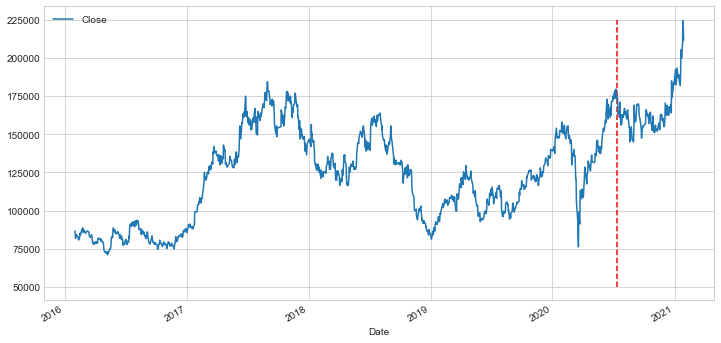

In [81]:
fig, ax = plt.subplots(figsize=(12,6))
stock_data.plot(ax=ax);
ax.vlines('2020-07-14', 50000, 225000, linestyle='--', color='r', label='Start of Forecast');
ax.plot(predict_index, predicted_value, label='Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA {auto_arima_model.order}, Prediction Results')
plt.show()